In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.pipeline import Pipeline
from math import sqrt

In [2]:
def import_data(path):
    data = pd.read_csv(path)
    return data

In [3]:
bitcoin_all = import_data('D:\\Studia\\W8\\Praca magisterska\\praca_magisterska\\data\\raw\\BTC-USD.csv')

Copying 'Date' column to set one as an index and convert second to integeres using mdates.date2num.
We need the dates as integers because you can’t feed dates into Support Vector Machines and neural networks

In [4]:
bitcoin_all['Date_num'] = bitcoin_all['Date']
bitcoin_all['Date_num'] = bitcoin_all['Date_num'].map(mdates.date2num)

In [5]:
bitcoin_all['Date'] = pd.to_datetime(bitcoin_all['Date'], infer_datetime_format=True)
bitcoin_all = bitcoin_all.set_index('Date')

In [6]:
bitcoin_all.tail()

,Open,High,Low,Close,Adj Close,Volume,Date_num
Date,,,,,,,
2020-10-21,11913.077148,13184.566406,11900.928711,12823.689453,12823.689453,4.341471e+10,18556.0
2020-10-22,12801.635742,13161.593750,12717.093750,12965.891602,12965.891602,3.472976e+10,18557.0
2020-10-23,12971.548828,13015.961914,12752.647461,12931.539063,12931.539063,2.897498e+10,18558.0
2020-10-24,12931.574219,13145.066406,12885.747070,13108.062500,13108.062500,2.454232e+10,18559.0
2020-10-25,13312.126953,13329.183594,12910.067383,12956.892578,12956.892578,2.804423e+10,18560.0


In [7]:
bitcoin_all.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
Date_num     0
dtype: int64

In [8]:
bitcoin_all[bitcoin_all.isnull().any(axis=1)]

,Open,High,Low,Close,Adj Close,Volume,Date_num
Date,,,,,,,
2020-08-04,NaN,NaN,NaN,NaN,NaN,NaN,18478.0


In [9]:
bitcoin_all = bitcoin_all.dropna() #remove row with at least one NaN

In [10]:
bitcoin_all.describe().round(2)

,Open,High,Low,Close,Adj Close,Volume,Date_num
count,1461.00,1461.00,1461.00,1461.00,1461.00,1.461000e+03,1461.00
mean,6681.33,6849.06,6503.68,6689.56,6689.56,1.254723e+10,17829.06
std,3622.76,3733.93,3488.55,3622.98,3622.98,1.265633e+10,421.99
min,654.00,664.42,653.70,657.59,657.59,5.260180e+07,17099.00
25%,3848.26,3916.42,3733.75,3851.05,3851.05,2.800890e+09,17464.00
50%,6971.18,7178.11,6793.82,6972.37,6972.37,7.073550e+09,17829.00
75%,9292.84,9457.42,9141.25,9303.63,9303.63,1.963222e+10,18194.00
max,19475.80,20089.00,18974.10,19497.40,19497.40,7.415677e+10,18560.00


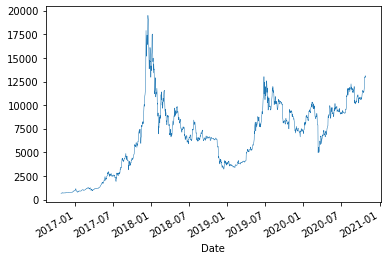

In [11]:
bitcoin_all['Close'].plot(linewidth=0.5);

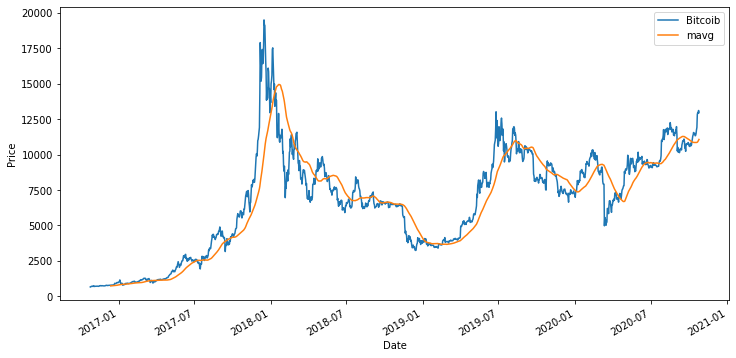

In [12]:
close_px = bitcoin_all['Close']
mavg = close_px.rolling(window=50).mean()
plt.figure(figsize = (12,6))
close_px.plot(label='Bitcoib')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [13]:
bitcoin_train=bitcoin_all['2016-10-25':'2019-10-25']
bitcoin_test=bitcoin_all['2019-10-26':'2020-10-25']

wyciagniecie jedynie ceny otwarcia i numerycznej daty do nowej dataframe

In [14]:
data_train= bitcoin_train[['Close', 'Date_num']]
data_test = bitcoin_test[['Close', 'Date_num']]

In [15]:
data_train.columns = ['price','date']
data_test.columns = ['price','date']

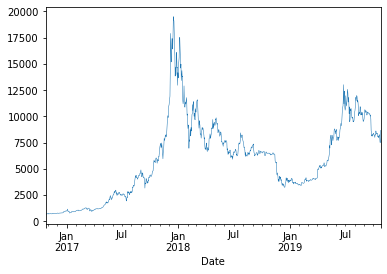

In [16]:
data_train.price.plot(linewidth=0.5);

In [17]:
data_train

,price,date
Date,,
2016-10-25,657.588013,17099.0
2016-10-26,678.304016,17100.0
2016-10-27,688.312988,17101.0
2016-10-28,689.651001,17102.0
2016-10-29,714.479004,17103.0
...,...,...
2019-10-21,8243.720703,18190.0
2019-10-22,8078.203125,18191.0
2019-10-23,7514.671875,18192.0


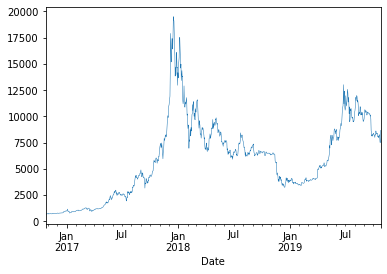

In [18]:
data_train['price'].plot(linewidth=0.5);

In [19]:
dates_train = data_train['date'].to_numpy()
prices_train = data_train['price'].to_numpy()
dates_test = data_test['date'].to_numpy()
prices_test = data_test['price'].to_numpy()

In [20]:
dates_train

array([17099., 17100., 17101., ..., 18192., 18193., 18194.])

In [21]:
#Convert to 1d Vector
dates_train = np.reshape(dates_train, (len(dates_train), 1))
prices_train = np.reshape(prices_train, (len(prices_train), 1))
dates_test = np.reshape(dates_test, (len(dates_test), 1))
prices_test = np.reshape(prices_test, (len(prices_test), 1))

In [22]:
scaler = StandardScaler().fit(prices_train)
prices_train = scaler.transform(prices_train)
#scaler_dates = StandardScaler().fit(dates_train)
#dates_train = scaler_dates.transform(dates_train)


In [56]:
scaler_dates

StandardScaler()

In [50]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
svr_rbf = GridSearchCV(SVR(), param_grid, refit = True, verbose = 2) 
  
# fitting the model for grid search 
svr_rbf.fit(dates_train, prices_train.ravel()) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.1s
[CV] 

[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[CV] ................. C=1000, gamma=0.0001, kernel=rbf, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] ................. C=1000, gamma=0.0001, kernel=rbf, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] ................. C=1000, gamma=0.0001, kernel=rbf, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] ................. C=1000, gamma=0.0001, kernel=rbf, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] ................. C=1000, gamma=0.0001, kernel=rbf, total=   0.1s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   30.8s finished


GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=2)

In [ ]:
svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.01, epsilon = 0.1)
svr_rbf.fit(dates_train, prices_train.ravel())

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(dates_train, scaler.inverse_transform(prices_train), color= 'black', label= 'Bitcoin prices train')
plt.plot(dates_test, prices_test, color= 'blue', label= 'Bitcoin prices test')
plt.plot(dates_train, scaler.inverse_transform(svr_rbf.predict(dates_train)), color= 'red', label= 'RBF model') 
plt.plot(dates_test, scaler.inverse_transform(svr_rbf.predict(dates_test)), color= 'green', label= 'RBF model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [59]:
scaler.inverse_transform(svr_rbf.predict(dates_test))

array([5873.29043246, 5873.18093954, 5873.18093954, 5873.18093954,
       5873.18093954, 5873.18093954, 5873.18093954, 5873.18093954,
       5873.18093954, 5873.18093954, 5873.18093954, 5873.18093954,
       5873.18093954, 5873.18093954, 5873.18093954, 5873.18093954,
       5873.18093954, 5873.18093954, 5873.18093954, 5873.18093954,
       5873.18093954, 5873.18093954, 5873.18093954, 5873.18093954,
       5873.18093954, 5873.18093954, 5873.18093954, 5873.18093954,
       5873.18093954, 5873.18093954, 5873.18093954, 5873.18093954,
       5873.18093954, 5873.18093954, 5873.18093954, 5873.18093954,
       5873.18093954, 5873.18093954, 5873.18093954, 5873.18093954,
       5873.18093954, 5873.18093954, 5873.18093954, 5873.18093954,
       5873.18093954, 5873.18093954, 5873.18093954, 5873.18093954,
       5873.18093954, 5873.18093954, 5873.18093954, 5873.18093954,
       5873.18093954, 5873.18093954, 5873.18093954, 5873.18093954,
       5873.18093954, 5873.18093954, 5873.18093954, 5873.18093